In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime, date, time, timedelta

from sklearn.metrics import auc, roc_curve, classification_report
from scipy import stats

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 1. Load the data

In [3]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/A collection of data challenge/13. Json city similarity/city_searches.json')

In [8]:
def data_preview(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({"data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)

Data processing

In [4]:
# 1. session id
data["session_id"] = list(map(lambda x:"".join(x), data.session_id))
# 2. session date, timestamp
data["unix_timestamp"] = list(map(lambda x: datetime.fromtimestamp(x[0]), data.unix_timestamp))
data["session_date"] = list(map(lambda x:x.date(), data.unix_timestamp))
data["session_time"] = list(map(lambda x:x.time(), data.unix_timestamp))
# 3. cities
data["num_cities"] = list(map(lambda x:len(x[0].split(",")),data.cities))
data["cities"] = list(map(lambda x: x[0], data.cities))

# 4. user
user_id = []
joining_date = []
country = []

for x in data.user:
  user_id.append(x[0][0]["user_id"])
  joining_date.append(x[0][0]["joining_date"])
  country.append(x[0][0]["country"])


data["user_id"] = user_id 
data["joining_date"] = pd.to_datetime(joining_date)
data["country"] = country

In [5]:
# drop the unused columns
data = data.drop(["unix_timestamp","user"],axis = 1)
data.head()

,session_id,cities,session_date,session_time,num_cities,user_id,joining_date,country
0,D258NVMV202LS,"San Jose CA, Montreal QC",2015-09-19,05:29:12,2,5749,2015-04-02,FR
1,TDG10UKG7I4LR,New York NY,2015-05-20,08:22:17,1,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,"Montreal QC, Quebec QC",2015-07-16,12:21:51,2,2941,2015-03-16,
3,CWHIAYKQ7RA28,Chicago IL,2015-05-21,13:45:08,1,2164,2015-03-27,FR
4,GI8GZJAWAC80P,"Toronto ON, Houston TX",2015-09-29,19:50:26,2,10493,2015-03-31,US


In [9]:
    data["hour"] = list(map(lambda x: x.hour, data["session_time"]))    

    # Hour of day
    def get_hourday(x):
        if 0<= x < 6:
            return "midnight"
        elif 6<= x < 12:
            return "morning"
        elif 12<= x < 18:
            return "afternoon"
        else:
            return "night"
    data["hourday"] = list(map(lambda x: get_hourday(x), data["hour"]))
    data["month"] = list(map(lambda x:x.month, data["session_date"]))

In [10]:
data_preview(data)

The dataset consists of 20022 rows and 11 columns
The columns are: ['session_id', 'cities', 'session_date', 'session_time', 'num_cities', 'user_id', 'joining_date', 'country', 'hour', 'hourday', 'month']


,session_id,cities,session_date,session_time,num_cities,user_id,joining_date,country,hour,hourday,month
data_types,object,object,object,object,int64,int64,datetime64[ns],object,int64,object,int64
value_counts,20022,1293,216,17141,8,9252,35,7,24,4,8
null_counts,0,0,0,0,0,0,0,0,0,0,0
0,D258NVMV202LS,"San Jose CA, Montreal QC",2015-09-19,05:29:12,2,5749,2015-04-02 00:00:00,FR,5,midnight,9
1,TDG10UKG7I4LR,New York NY,2015-05-20,08:22:17,1,10716,2015-03-30 00:00:00,DE,8,morning,5
2,OH4ZDIGN9BLQS,"Montreal QC, Quebec QC",2015-07-16,12:21:51,2,2941,2015-03-16 00:00:00,,12,afternoon,7


# Question 1
There was a bug in the code and one country didn't get logged. It just shows up as an
empty field (""). Can you guess which country was that? How?

In [ ]:
# DE: Germany
# ES: Spain
# IT: Italy

# Seem like China or other Asian countries
data.groupby("country").hour.mean()

country
       6.624774
DE    11.092756
ES    11.052719
FR    10.970525
IT    11.157895
UK    12.062067
US    16.600212
Name: hour, dtype: float64

For the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in **Asia**. Possible countries include **China** and **Japan**.

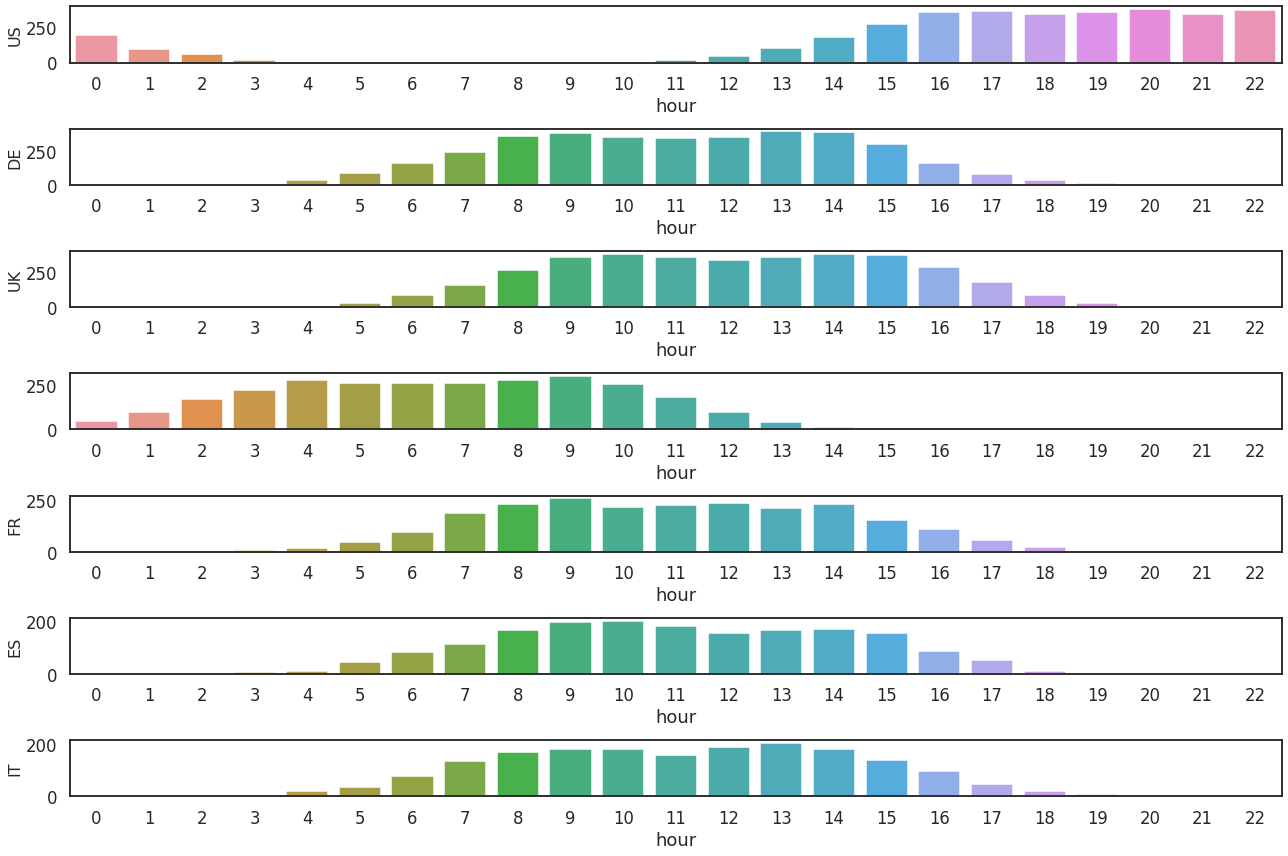

In [12]:
# visualization
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=16)
plt.tight_layout()
plt.show()

# Question 2
For each city, find the most likely city to be also searched for within the same session

In [ ]:
temp = data["cities"].str.split(",",expand = True).stack().reset_index(level = 1,drop = True).rename("cities")
unstack_data = data.drop("cities",axis = 1).join(temp).reset_index().drop("index",axis = 1)
unstack_data.head()

,session_id,session_date,session_time,num_cities,user_id,joining_date,country,hour,hourday,cities
0,D258NVMV202LS,2015-09-19,05:29:12,2,5749,2015-04-02,FR,5,midnight,San Jose CA
1,D258NVMV202LS,2015-09-19,05:29:12,2,5749,2015-04-02,FR,5,midnight,Montreal QC
2,TDG10UKG7I4LR,2015-05-20,08:22:17,1,10716,2015-03-30,DE,8,morning,New York NY
3,OH4ZDIGN9BLQS,2015-07-16,12:21:51,2,2941,2015-03-16,,12,afternoon,Montreal QC
4,OH4ZDIGN9BLQS,2015-07-16,12:21:51,2,2941,2015-03-16,,12,afternoon,Quebec QC


### Step 1: build the session-city matrix


In [ ]:
session_city = unstack_data.groupby(['cities', 'session_id'])['user_id'].count().unstack(fill_value=0)
session_city.head()

session_id,005DKBSO9FEZL,006EM84U68V9I,009CAJV5IDV7Q,00AR2ULVTS3JY,00B1MRZFC6KZM,00ECL2HO5RGIW,00G9GB0GWO8PW,00I2VFNJ8QTC9,00ITMX33BZOAE,00MQZE4YMB1JZ,00PG1IZUD7ZT5,00QTM18RE04HU,00TG41QOIGLA6,00VBD8LQGMHJU,00WQ6R3AAOYB5,00WVQGYDHK40O,00XLXZWABYCFS,00Y5DBEIEHBBE,00YOW6UO9JVGO,00ZEOL1JVT2KT,0104PDOFRVFFQ,010YZWYON7CTV,01102JMKKTP0D,011YV7N405QJ7,0120CMNLNQS4H,013D5ZP9F9BZ1,014CM4PT1PS0B,014U9X1VLSO5R,01B8TX0F3PRSP,01CG7CO8KTDTH,01CMPRDMP3D0N,01CTB7XG2SEFF,01E98E087T6LV,01L8MNWBV1NNG,01MNTBLVMLYEV,01O79Z8Y5ZNQC,01RSMHP9Y6RPT,01SR8Q7V7Q4XE,01TYQ5DPBJ28C,01UTEE678I3C6,...,ZXAEUFDX5T4OO,ZXB78OA2YQL8Z,ZXI7VFXWDDKHM,ZXIKPGL0TABHV,ZXLTMPBZF2C51,ZXO66EYYNM7KU,ZXP2GF80HAYI0,ZXSND2HV55L2J,ZXSUDLW4FIO7D,ZXSYJDD8SAHQD,ZXZYV05NS605F,ZY8OT01XH0ES2,ZYADDR03Y1MAG,ZYFW7XWQSZTW0,ZYGVSQEA3AD7L,ZYJGUY9G66PR0,ZYN7NLQD04JHW,ZYR19W5BECQY4,ZYS5EKI8W0Q4O,ZYSSHKS8MPCGL,ZYUR9VMSO4KWG,ZYX3EEF0LJDF2,ZZ1YWYKCTG7L2,ZZ39RFBVBFB4X,ZZ9MRUMXAG1M6,ZZ9UIOQZPKC8T,ZZBLNFYHBOE3E,ZZD8PBTX9OGZR,ZZFQL561XHRL1,ZZII3FOXRUF14,ZZL0QPL2U0JHY,ZZLE164R30I49,ZZMURXIX4P9NE,ZZQVN2S7OONOB,ZZROE38IE7XY6,ZZTH5MZ1DY4PX,ZZWVLMEY5H5DM,ZZXKUGEYHZXOJ,ZZYCEP57WDPTC,ZZZ3P5GW1PJWL
cities,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anaheim CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Percentage of certain cities being searched within a session
session_city.T.describe()

cities,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,Chandler AZ,Charlotte NC,Chesapeake VA,Chicago IL,Cincinnati OH,Cleveland OH,Columbus OH,Corpus Christi TX,Dallas TX,Detroit MI,Edmonton AB,Fort Wayne IN,Fort Worth TX,Fresno CA,Glendale AZ,Halifax NS,Hamilton ON,Hialeah FL,Houston TX,Indianapolis IN,Jersey City NJ,Kansas City MO,Kitchener ON,Lexington KY,Lincoln NE,London ON,Long Beach CA,Los Angeles CA,Louisville KY,Madison WI,...,Saint Petersburg FL,San Antonio TX,San Diego CA,San Francisco CA,San Jose CA,Santa Ana CA,Scottsdale AZ,Seattle WA,Stockton CA,Tampa FL,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON,Calgary AB,Chicago IL,Columbus OH,Dallas TX,Detroit MI,Edmonton AB,Houston TX,Indianapolis IN,Jacksonville FL,Los Angeles CA,Montreal QC,New York NY,OTTAWA ON,Philadelphia PA,Phoenix AZ,San Antonio TX,San Diego CA,San Jose CA,Toronto ON,Vancouver BC
count,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.00000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.00000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,...,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.00000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000,20022.000000
mean,0.013785,0.007492,0.001199,0.012137,0.001349,0.011437,0.000350,0.00889,0.007342,0.004295,0.002847,0.000100,0.000450,0.027420,0.005294,0.002347,0.000749,0.006693,0.003196,0.001049,0.004545,0.007991,0.005844,0.000999,0.003596,0.000400,0.011587,0.001299,0.022375,0.003296,0.033263,0.00015,0.006593,0.003196,0.000200,0.001748,0.016182,0.038008,0.002797,0.006293,...,0.001848,0.004046,0.001548,0.002547,0.000050,0.014384,0.002797,0.007492,0.002048,0.002347,0.005144,0.049146,0.000749,0.000250,0.022026,0.009639,0.000499,0.003796,0.000300,0.003446,0.023424,0.071571,0.018630,0.028918,0.020228,0.019828,0.049945,0.019878,0.021227,0.097593,0.086005,0.202927,0.020927,0.03666,0.034612,0.031665,0.035761,0.021826,0.113425,0.044951
std,0.116600,0.086232,0.034602,0.109499,0.036698,0.106335,0.018695,0.09387,0.085372,0.065399,0.053281,0.009994,0.021197,0.163307,0.072570,0.048394,0.027362,0.081536,0.056448,0.032370,0.067265,0.089038,0.076221,0.031590,0.059861,0.019986,0.107021,0.036013,0.147905,0.057321,0.179328,0.01224,0.080930,0.056448,0.014133,0.041774,0.126179,0.191221,0.052813,0.079081,...,0.042949,0.063477,0.039319,0.050407,0.007067,0.119071,0.052813,0.086232,0.045207,0.048394,0.071541,0.216178,0.027362,0.015801,0.146771,0.097709,0.022343,0.061495,0.017309,0.058605,0.151250,0.257783,0.135216,0.167581,0.140782,0.139413,0.217837,0.139585,0.144143,0.296770,0.280379,0.402188,0.143144,0.18793,0.182799,0.175111,0.185697,0.146119,0.317120,0.207201
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

### Step 2: construct the similarity matrix
the size of the similarity matrix is **105×105**, each dimension includes all unique cities;    
Each cell then represents the total number of sessions that these two cities are search together   
  
We need to *normalize* the value before proceeding because some cities are more popular and are searched more often

In [ ]:
from sklearn.preprocessing import normalize
session_city_norm = normalize(session_city, axis=1)  # normalize the song-user matrix

sim_mat = np.dot(session_city_norm, session_city_norm.T)  

sim_cities = pd.DataFrame(sim_mat, index=session_city.index, columns=session_city.index)
sim_cities.head()


cities,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,Chandler AZ,Charlotte NC,Chesapeake VA,Chicago IL,Cincinnati OH,Cleveland OH,Columbus OH,Corpus Christi TX,Dallas TX,Detroit MI,Edmonton AB,Fort Wayne IN,Fort Worth TX,Fresno CA,Glendale AZ,Halifax NS,Hamilton ON,Hialeah FL,Houston TX,Indianapolis IN,Jersey City NJ,Kansas City MO,Kitchener ON,Lexington KY,Lincoln NE,London ON,Long Beach CA,Los Angeles CA,Louisville KY,Madison WI,...,Saint Petersburg FL,San Antonio TX,San Diego CA,San Francisco CA,San Jose CA,Santa Ana CA,Scottsdale AZ,Seattle WA,Stockton CA,Tampa FL,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON,Calgary AB,Chicago IL,Columbus OH,Dallas TX,Detroit MI,Edmonton AB,Houston TX,Indianapolis IN,Jacksonville FL,Los Angeles CA,Montreal QC,New York NY,OTTAWA ON,Philadelphia PA,Phoenix AZ,San Antonio TX,San Diego CA,San Jose CA,Toronto ON,Vancouver BC
cities,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anaheim CA,1.000000,0.000000,0.0,0.000000,0.057921,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.013460,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.344437,0.015274,0.0,0.0,...,0.000000,0.000000,0.162165,0.0,0.0,0.450457,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.295490,0.0,0.0,0.0,0.0,0.0,0.000000,0.130472,0.002879,0.0,0.0
Arlington TX,0.000000,1.000000,0.0,0.235702,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.134016,0.255155,0.0,0.0,0.0,0.422717,0.000000,0.0,0.0,0.0,0.000000,0.027003,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.108866,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.073030,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.203595,0.0,0.0,0.157501,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.094039,0.000000,0.000000,0.0,0.0
Atlanta GA,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.46291,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.019826,0.0,0.052705,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.080064,0.000000,0.0,0.0,0.0,0.0,0.076547,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.067116,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.059549,0.020113,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.237635,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
Austin TX,0.000000,0.235702,0.0,1.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.160710,0.168394,0.0,0.0,0.0,0.243158,0.000000,0.0,0.0,0.0,0.000000,0.066678,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.313622,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.028689,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.095975,0.0,0.0,0.265747,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.193627,0.000000,0.000000,0.0,0.0
Bakersfield CA,0.057921,0.000000,0.0,0.000000,1.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.301232,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.021383,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.011340,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095781,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.046031,0.0,0.0


In [ ]:
# Step 3: find the top-k most similar songs
def find_topk(city, similarity, k=1):
    df = similarity.loc[city].sort_values(ascending=False)[1:k + 1].reset_index()
    df = df.rename(columns={'cities': 'cities_searched_together', city: 'Similarity'})
    
    return df

In [ ]:
find_topk(" Anaheim CA",sim_cities, k = 10)

,cities_searched_together,Similarity
0,Santa Ana CA,0.450457
1,Long Beach CA,0.344437
2,Los Angeles CA,0.295490
3,Riverside CA,0.291417
4,San Diego CA,0.162165
5,San Diego CA,0.130472
6,Bakersfield CA,0.057921
7,Los Angeles CA,0.015274
8,Fresno CA,0.013460
9,San Jose CA,0.002879


# 3. Question 3
Come up with an algorithm that clusters sessions into
two groups: high intent and low intent. Explain all assumptions you make along the way.   

I would consider rule-based algorithms for interpretation concern, rather than K-Means

**Assumptions**
1. Users tend to first search for interest (low intent), and then search for planning (high intent) along their user journey. In other words, people only plan their cities of visit after having going through at least once
2. Two cities are closed if they reside within the same state

### High intent sessions
- All the cities searched in this session has been searched by the corresponding user before (thus can't be the first session..)
- Focus on just 1 city, or multiple cities if they are in the same state (I don't think this is always the case because location is not such an important factor, but anyways)  

### Low intent sessions
- At least 1 city searched in this session has not been searched by the corresponding user before (including first session..)
- If the session only includes 1 city, then this city has not been searched before; if the session includes multiple city, then they are from different **countries**   

### Others 
The left portion

Other thoughts:
1. score-based algo? but the fact that there are no labels making this hard to determine the threshold
2. individualized algo (by user/by country)? Too few columns to justify